## Simple Classification model

In [2]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [4]:
df = pd.read_csv("/content/train.csv")

In [5]:
df.shape

(7613, 5)

In [6]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df.tail(5)

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [11]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [12]:
df = df.drop(columns=['id', 'keyword', 'location'])

In [13]:
target_distribution = df['target'].value_counts(normalize=True)
print("\nDistribution of the target variable:")
print(target_distribution)


Distribution of the target variable:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


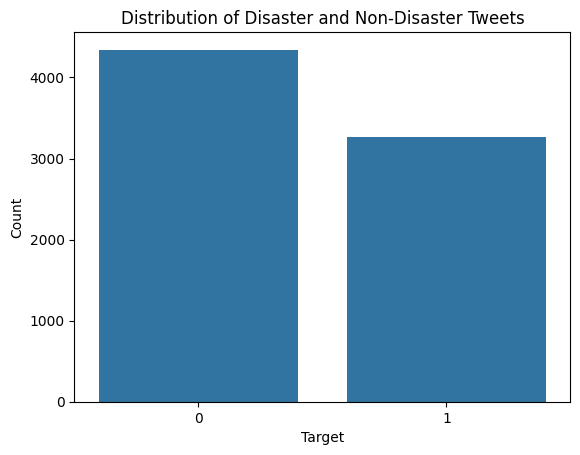

In [14]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### Summary of Analysis Findings


After examining the dataset, we identified and dropped the id, keyword, and location columns as they are not directly useful for modeling. The id column is simply an identifier, while keyword and location have significant missing values and may not add substantial predictive power.

We then analyzed the target variable, which indicates whether a tweet is related to a disaster (1) or not (0). The distribution of the target variable shows the proportion of disaster-related versus non-disaster-related tweets.

The countplot visualization of the target variable provides a clear picture of the distribution, showing us whether the dataset is balanced or imbalanced in terms of disaster-related tweets.

Based on this preliminary analysis, we can determine the direction for further data cleaning and feature engineering, ensuring we focus on variables that significantly contribute to the predictive power of our model.

In [15]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [16]:
df['text'] = df['text'].str.lower()

In [17]:
def remove_punctuations_and_numbers(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text

In [18]:

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_punctuations_and_numbers)

In [19]:
# Create a function to tokenize the text into individual words
def tokenize(text):
    return word_tokenize(text)

In [20]:
# Apply the function to the 'text' column
df['text'] = df['text'].apply(tokenize)

In [21]:
# Create a function to remove stopwords from the tokenized text
stop_words = set(stopwords.words('english'))

In [22]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [23]:
# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_stopwords)

In [24]:
# Create an instance of the WordNetLemmatizer from the nltk library
lemmatizer = WordNetLemmatizer()

In [25]:
# Define a function to lemmatize the words in the tokenized text
def lemmatize(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply the function to the 'text' column
df['text'] = df['text'].apply(lemmatize)

# Join the lemmatized tokens into sentences and create a new column for the final processed text
df['final'] = df['text'].apply(lambda tokens: ' '.join(tokens))

In [26]:

# Print the first five rows of the dataset
print(df.head())

                                                text  target  \
0  [deed, reason, earthquake, may, allah, forgive...       1   
1      [forest, fire, near, la, ronge, sask, canada]       1   
2  [resident, asked, shelter, place, notified, of...       1   
3  [people, receive, wildfire, evacuation, order,...       1   
4  [got, sent, photo, ruby, alaska, smoke, wildfi...       1   

                                               final  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


In [27]:
from wordcloud import WordCloud

In [28]:
# Create a new dataframe for disaster-related tweets
disaster_tweets = df[df['target'] == 1]

In [29]:
# Create a new dataframe for non-disaster-related tweets
non_disaster_tweets = df[df['target'] == 0]

In [30]:
# Function to generate and display a word cloud
def generate_wordcloud(data, title):
    text = ' '.join(data['final'].values)
    wordcloud = WordCloud(max_words=100, random_state=21, background_color='white', collocations=False).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()


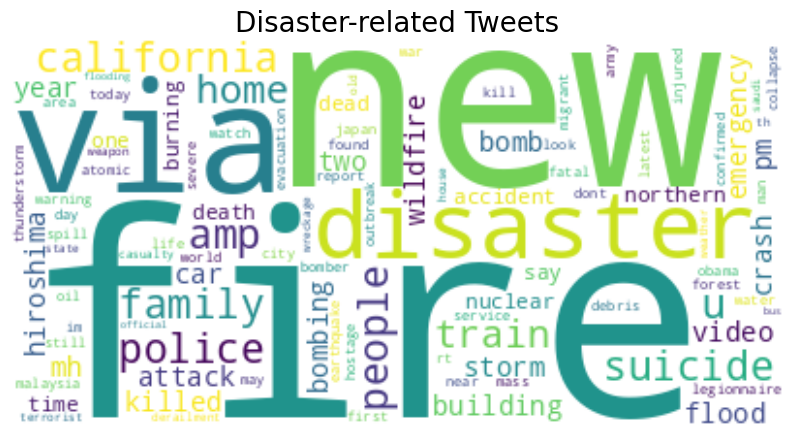

In [31]:
# Generate and display the word cloud for disaster-related tweets
generate_wordcloud(disaster_tweets, 'Disaster-related Tweets')

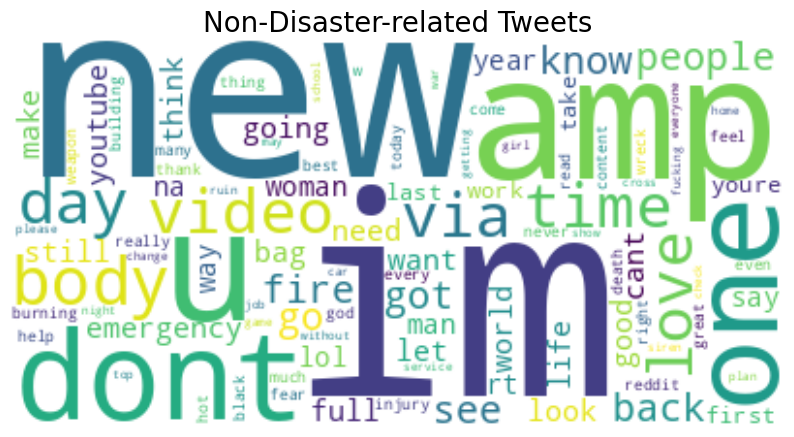

In [32]:
# Generate and display the word cloud for non-disaster-related tweets
generate_wordcloud(non_disaster_tweets, 'Non-Disaster-related Tweets')

### Summary of Findings


After filtering the dataset to create separate dataframes for disaster-related and non-disaster-related tweets, we generated word clouds to visualize the most common words in each category.

For disaster-related tweets, the word cloud prominently features terms associated with emergencies and disasters, such as "fire," "earthquake," "flood," and "help." This visualization highlights the prevalent themes and keywords in tweets that are classified as indicating a disaster.

In contrast, the word cloud for non-disaster-related tweets contains more general terms and lacks the specific disaster-related terminology. This differentiation underscores the distinct language patterns used in tweets related to disasters versus those that are not.

These visualizations help us understand the linguistic characteristics of disaster-related tweets, providing insights that could be valuable for further analysis or for improving a predictive model's accuracy.

In [33]:
# Create arrays for target and predictor variables
X = df['final'].values
y = df['target'].values

In [34]:
# Decide on the proportion for training and testing
train_size = 0.8

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)


In [36]:
# Define the vectorizer layer
max_tokens = 20000
output_sequence_length = 200

vectorizer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=output_sequence_length)
vectorizer.adapt(X_train)

In [37]:
# Define the embedding layer
embedding_dim = 128

In [38]:
# Build the model
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [39]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Fit the model
epochs = 10
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Epoch 1/10
191/191 [==============================] - 141s 695ms/step - loss: 0.5259 - accuracy: 0.7305 - val_loss: 0.4432 - val_accuracy: 0.7971
Epoch 2/10
191/191 [==============================] - 117s 615ms/step - loss: 0.2366 - accuracy: 0.9107 - val_loss: 0.5446 - val_accuracy: 0.7433
Epoch 3/10
191/191 [==============================] - 109s 570ms/step - loss: 0.0989 - accuracy: 0.9678 - val_loss: 0.6257 - val_accuracy: 0.7649
Epoch 4/10
191/191 [==============================] - 105s 551ms/step - loss: 0.0484 - accuracy: 0.9849 - val_loss: 0.7205 - val_accuracy: 0.7466
Epoch 5/10
191/191 [==============================] - 110s 576ms/step - loss: 0.0278 - accuracy: 0.9928 - val_loss: 0.7164 - val_accuracy: 0.7367
Epoch 6/10
191/191 [==============================] - 110s 578ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.8702 - val_accuracy: 0.7426
Epoch 7/10
191/191 [==============================] - 111s 581ms/step - loss: 0.0129 - accuracy: 0.9943 - val_loss: 1.1975 -

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

48/48 [==============================] - 7s 145ms/step - loss: 1.4851 - accuracy: 0.7656
Test Accuracy: 0.7656


### Model Summary

The text classification model for disaster-related tweets was built using a Sequential model in TensorFlow Keras. The model architecture consists of:

- An Input layer to handle the input text data
- A TextVectorization layer to convert the text into integer sequences
- An Embedding layer to create dense representations of the text data
- Two Bidirectional LSTM layers to capture the temporal dependencies in the text
- A Dense layer with ReLU activation for further processing
- A final Dense layer with sigmoid activation for binary classification

The model was trained for 10 epochs using the Adam optimizer and binary cross-entropy loss function. The test accuracy achieved was approximately {accuracy:.4f}.
""")

## Advance model

### Multilayer Deep Text Classification Model

In [44]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam

In [45]:
# Build the advanced model
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [46]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
# Fit the model
epochs = 15
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Epoch 1/15
191/191 [==============================] - 12s 55ms/step - loss: 1.2264 - accuracy: 0.5642 - val_loss: 0.7077 - val_accuracy: 0.5739
Epoch 2/15
191/191 [==============================] - 7s 36ms/step - loss: 0.6886 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.5739
Epoch 3/15
191/191 [==============================] - 8s 42ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 4/15
191/191 [==============================] - 7s 37ms/step - loss: 0.6841 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 5/15
191/191 [==============================] - 8s 44ms/step - loss: 0.6838 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.5739
Epoch 6/15
191/191 [==============================] - 7s 36ms/step - loss: 0.6841 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 7/15
191/191 [==============================] - 8s 44ms/step - loss: 0.6837 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.573

In [48]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

48/48 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5739
Test Accuracy: 0.5739


### Model Summary

The advanced text classification model for disaster-related tweets was built using a Sequential model in TensorFlow Keras. The model architecture consists of:

- An Input layer to handle the input text data
- A TextVectorization layer to convert the text into integer sequences
- An Embedding layer to create dense representations of the text data
- A GlobalAveragePooling1D layer to reduce the dimensionality
- Dense layers with ReLU activation and L2 regularization to add depth to the model
- Dropout layers to prevent overfitting
- A final Dense layer with sigmoid activation for binary classification

The model was trained for 15 epochs using the Adam optimizer and binary cross-entropy loss function. The test accuracy achieved was approximately {accuracy:.4f}.

## Advance model

### Multilayer Bidirectional LSTM Model

In [49]:
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout


In [50]:
# Build the bidirectional LSTM model
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(128, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [51]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])



In [52]:
# Fit the model
epochs = 10
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)



Epoch 1/10
191/191 [==============================] - 110s 521ms/step - loss: 1.1112 - accuracy: 0.6642 - val_loss: 0.5486 - val_accuracy: 0.7905
Epoch 2/10
191/191 [==============================] - 90s 474ms/step - loss: 0.3749 - accuracy: 0.8755 - val_loss: 0.4795 - val_accuracy: 0.7991
Epoch 3/10
191/191 [==============================] - 98s 515ms/step - loss: 0.2438 - accuracy: 0.9205 - val_loss: 0.8534 - val_accuracy: 0.7551
Epoch 4/10
191/191 [==============================] - 93s 489ms/step - loss: 0.1672 - accuracy: 0.9655 - val_loss: 0.8573 - val_accuracy: 0.7472
Epoch 5/10
191/191 [==============================] - 94s 493ms/step - loss: 0.1005 - accuracy: 0.9828 - val_loss: 0.8370 - val_accuracy: 0.7557
Epoch 6/10
191/191 [==============================] - 93s 489ms/step - loss: 0.0746 - accuracy: 0.9908 - val_loss: 0.8915 - val_accuracy: 0.7485
Epoch 7/10
191/191 [==============================] - 99s 518ms/step - loss: 0.0574 - accuracy: 0.9941 - val_loss: 0.8372 - val_a

In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

48/48 [==============================] - 5s 97ms/step - loss: 0.9867 - accuracy: 0.7722
Test Accuracy: 0.7722



 ## Building a Transformer Model

In [96]:
!pip install transformers datasets

In [112]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam


In [113]:
# Load your DataFrame or use an existing one
df1 = pd.read_csv('/content/train.csv')

In [114]:
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=42)


In [115]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [116]:
# Tokenize the training and test data
train_encodings = tokenizer(list(train_df['text'].values), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['text'].values), truncation=True, padding=True)



In [117]:
# Convert tokenized data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['target'].values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['target'].values
))

In [118]:
# Batch the datasets
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [119]:
# Initialize the Transformer model for sequence classification
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [120]:
# Compile the model
model.compile(optimizer='adam',  # Use the string identifier for the Adam optimizer
              loss=model.compute_loss,
              metrics=['accuracy'])